In [4]:
import pickle
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt  
import numpy as np 
import cartopy 
import cartopy.crs as ccrs
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from eod import msg
from eod import trmm

In [5]:
msg_folder = '/users/global/cornkle/data/OBS/meteosat_WA30'
trmm_folder = '/users/global/cornkle/data/pythonWorkspace/proj_CEH/eod/tests/test_files/trmm'

In [6]:
mobj = msg.ReadMsg(msg_folder)

In [8]:
mobj.set_date(2006, 6, 24, 4, 30)
dd = mobj.get_data()

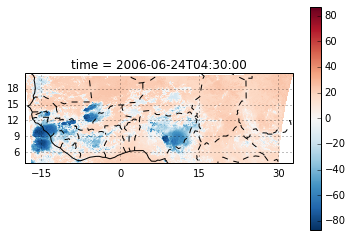

In [11]:
ax = plt.axes(projection=ccrs.PlateCarree())
dd.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat')
ax.coastlines(); 
# Gridlines
xl = ax.gridlines(draw_labels=True);
xl.xlabels_top = False
xl.ylabels_right = False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--');

In [6]:
mobj = trmm.ReadWA(trmm_folder)

2785
3515


In [7]:
t = mobj.get_data(mobj.fpaths[0])

[2007, 2007]


AttributeError: 'tuple' object has no attribute 'isel'